# Porting an analysis from local to distributed

<a href = "http://yogen.io"><img src="http://yogen.io/assets/logo.svg" alt="yogen" style="width: 200px; float: right;"/></a>

Now comes the opportunity to put in practice what we have just learned!

### If you are running this notebook in Google Colab

Copy the following to a code cell and run it. It will install and set up Spark for you.

```python
!pip install pyspark==3.1.1
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config("spark.ui.port", "4050").getOrCreate() ## For ngrok to tunnel to
```

In [1]:
!pip install pyspark==3.1.1
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config("spark.ui.port", "4050").getOrCreate() ## For ngrok to tunnel to

     |████████████████████████████████| 212.3MB 67kB/s 
     |████████████████████████████████| 204kB 21.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=00747874df3a71fec6754315eaa5d3407f277208585b6ab49dcdfb802fddfb85
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


# Guided exercise

Recreate the boxplot we did in the pandas section, in Spark!

Since matplotlib boxplot needs all the data and that would be unfeasible with Big Data, we will calculate the quartiles ourselves.

Once the analysis is ported, we will be able to run it on the whole historical series! You can find it at https://transtats.bts.gov (On time performance reporting carrier).

##  Workflow

The basic idea is the same that we applied in the Amadeus Challenge:

* Build prototype with small data: in this section, we will be using `06-intro_to_pandas_practical.ipynb` as our already made prototype

* Modify your prototype so that it works with Big Data: In this case, it means porting it to Spark

* Test your "Big Data" prototype with small data: We will first test it with a sample locally, then upload it to a cluster and test it with Big Data.

    * You can run your analyses building your own cluster and storage bucket in Google Cloud Storage. More in notebook #4!

* Run your prototype with Big Data.

    


## Modify the prototype so that it works with Big Data

In [2]:
!unzip On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2020_3\ \(2\).zip

Archive:  On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2020_3 (2).zip
  inflating: On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2020_3.csv  
  inflating: readme.html             


In [8]:
!head -n 2 On_Time_Reporting_Carrier_On_Time_Performance_\(1987_present\)_2020_3.csv

"Year","Quarter","Month","DayofMonth","DayOfWeek","FlightDate","Reporting_Airline","DOT_ID_Reporting_Airline","IATA_CODE_Reporting_Airline","Tail_Number","Flight_Number_Reporting_Airline","OriginAirportID","OriginAirportSeqID","OriginCityMarketID","Origin","OriginCityName","OriginState","OriginStateFips","OriginStateName","OriginWac","DestAirportID","DestAirportSeqID","DestCityMarketID","Dest","DestCityName","DestState","DestStateFips","DestStateName","DestWac","CRSDepTime","DepTime","DepDelay","DepDelayMinutes","DepDel15","DepartureDelayGroups","DepTimeBlk","TaxiOut","WheelsOff","WheelsOn","TaxiIn","CRSArrTime","ArrTime","ArrDelay","ArrDelayMinutes","ArrDel15","ArrivalDelayGroups","ArrTimeBlk","Cancelled","CancellationCode","Diverted","CRSElapsedTime","ActualElapsedTime","AirTime","Flights","Distance","DistanceGroup","CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay","FirstDepTime","TotalAddGTime","LongestAddGTime","DivAirportLandings","DivReachedDest","DivAc

## Read csv

We'll use the `SparkSession.read.csv` method.

In [9]:
df = spark.read.csv('/content/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2020_3.csv', inferSchema=True, header=True)
df

DataFrame[Year: int, Quarter: int, Month: int, DayofMonth: int, DayOfWeek: int, FlightDate: string, Reporting_Airline: string, DOT_ID_Reporting_Airline: int, IATA_CODE_Reporting_Airline: string, Tail_Number: string, Flight_Number_Reporting_Airline: int, OriginAirportID: int, OriginAirportSeqID: int, OriginCityMarketID: int, Origin: string, OriginCityName: string, OriginState: string, OriginStateFips: int, OriginStateName: string, OriginWac: int, DestAirportID: int, DestAirportSeqID: int, DestCityMarketID: int, Dest: string, DestCityName: string, DestState: string, DestStateFips: int, DestStateName: string, DestWac: int, CRSDepTime: int, DepTime: int, DepDelay: double, DepDelayMinutes: double, DepDel15: double, DepartureDelayGroups: int, DepTimeBlk: string, TaxiOut: double, WheelsOff: int, WheelsOn: int, TaxiIn: double, CRSArrTime: int, ArrTime: int, ArrDelay: double, ArrDelayMinutes: double, ArrDel15: double, ArrivalDelayGroups: int, ArrTimeBlk: string, Cancelled: double, CancellationC

In [10]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: string (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- DOT_ID_Reporting_Airline: integer (nullable = true)
 |-- IATA_CODE_Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- OriginCityMarketID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateFips: integer (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- OriginWac: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DestAirportSeqID

## Select relevant columns

Literally the same syntax as Pandas!

```python
df = df[['FlightDate', 'DayOfWeek', 'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                'DepTime', 'DepDelay', 'AirTime', 'Distance']]

df
```

In [12]:
df = df[['FlightDate', 'DayOfWeek', 'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                'DepTime', 'DepDelay', 'AirTime', 'Distance']]
 
df.show(5)

+----------+---------+-----------------+-----------+-------------------------------+------+-----------------+---------------+----+-----------------+-------------+-------+--------+-------+--------+
|FlightDate|DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|   OriginCityName|OriginStateName|Dest|     DestCityName|DestStateName|DepTime|DepDelay|AirTime|Distance|
+----------+---------+-----------------+-----------+-------------------------------+------+-----------------+---------------+----+-----------------+-------------+-------+--------+-------+--------+
|2020-03-09|        1|               9E|     N669CA|                           4677|   DTW|      Detroit, MI|       Michigan| PVD|   Providence, RI| Rhode Island|   1412|   -11.0|   84.0|   615.0|
|2020-03-09|        1|               9E|     N669CA|                           4677|   PVD|   Providence, RI|   Rhode Island| DTW|      Detroit, MI|     Michigan|   1646|    -4.0|  102.0|   615.0|
|2020-03-07|   

### Extract "Hour" variable

The DepTimes have been inferred to be floats. We need them as ints, representing each o fthe 24 hours in a day.

## Generate the relative distributions

In order to be able to handle the data, we need to reduce its dimensionality. Since we want to describe a discrete distribution, we can just count how many values of each level of the 'DepDelay' variable we find for each hour (24 different discrete distributions). We also want the totals in order to do the relative distribution.

### Totals

In [16]:
totals = df.groupby('FlightDate').count()
totals

DataFrame[FlightDate: string, count: bigint]

### Distributions

In [22]:
distributions = df.groupby(['FlightDate', 'DepDelay']).count()
distributions.show(20)

+----------+--------+-----+
|FlightDate|DepDelay|count|
+----------+--------+-----+
|2020-03-27|    50.0|    9|
|2020-03-18|    65.0|   10|
|2020-03-23|   -14.0|  258|
|2020-03-20|    48.0|   23|
|2020-03-18|    23.0|   26|
|2020-03-30|    29.0|   10|
|2020-03-09|     2.0|  244|
|2020-03-22|    52.0|   10|
|2020-03-06|    77.0|   10|
|2020-03-01|    67.0|    8|
|2020-03-23|    32.0|   21|
|2020-03-25|    26.0|   17|
|2020-03-14|    11.0|  117|
|2020-03-16|    40.0|   12|
|2020-03-28|     7.0|   29|
|2020-03-31|     5.0|   41|
|2020-03-18|    36.0|   12|
|2020-03-29|   833.0|    1|
|2020-03-31|    48.0|    3|
|2020-03-04|   375.0|    1|
+----------+--------+-----+
only showing top 20 rows



In [23]:
from pyspark.sql import functions

functions.collect_list

In [28]:
lists = distributions.groupby('FlightDate').agg(functions.collect_list('DepDelay').alias('depdelays'),
                                                functions.collect_list('count').alias('counts'))
lists.cache().show(5)

+----------+--------------------+--------------------+
|FlightDate|           depdelays|              counts|
+----------+--------------------+--------------------+
|2020-03-16|[40.0, 331.0, 266...|[12, 1, 1, 46, 2,...|
|2020-03-03|[197.0, 56.0, 215...|[1, 7, 1, 1349, 3...|
|2020-03-06|[77.0, 552.0, 267...|[10, 1, 1, 2, 7, ...|
|2020-03-26|[120.0, 67.0, 131...|[1, 7, 2, 3, 1, 1...|
|2020-03-05|[70.0, 24.0, 196....|[4, 41, 2, 35, 3,...|
+----------+--------------------+--------------------+
only showing top 5 rows



Now we join both and calculate what fraction of the total for each hour each level of DepDelay represents.

In [30]:
joined = totals.join(lists, on='FlightDate')
joined.show(5)

+----------+-----+--------------------+--------------------+
|FlightDate|count|           depdelays|              counts|
+----------+-----+--------------------+--------------------+
|2020-03-16|22071|[40.0, 331.0, 266...|[12, 1, 1, 46, 2,...|
|2020-03-03|20454|[197.0, 56.0, 215...|[1, 7, 1, 1349, 3...|
|2020-03-26|21344|[120.0, 67.0, 131...|[1, 7, 2, 3, 1, 1...|
|2020-03-06|21537|[77.0, 552.0, 267...|[10, 1, 1, 2, 7, ...|
|2020-03-05|21428|[70.0, 24.0, 196....|[4, 41, 2, 35, 3,...|
+----------+-----+--------------------+--------------------+
only showing top 5 rows



In [55]:
def quartiles(total, delays, counts):

  histogram = sorted(zip(delays, counts))

  result = []
  so_far = 0.0
  

  for delay, n in histogram:
    prev = so_far
    so_far += n / total

    if prev == 0.0:
      result.append(delay)
    if prev < .25 and so_far >= .25:
      result.append(delay)
    if prev < .5 and so_far >= .5:
      result.append(delay)
    if prev < .75 and so_far >= .75:
      result.append(delay)
    
  result.append(delay)

  return result

delays = [ 6, 9, -10, -5, 0, 3,10]
counts = [4, 7, 5, 12, 11, 98, 2]

quartiles(sum(counts), delays, counts)

[-10, 3, 3, 3, 10]

In [56]:
import numpy as np
unrolled = [ n for delay, count in zip(delays, counts) for n in [delay] * count ]
np.percentile(unrolled, [0, 25, 50, 75, 100])

array([-10.,   3.,   3.,   3.,  10.])

In [64]:
from pyspark.sql import types

@functions.udf(types.ArrayType(types.FloatType()))
def quartiles(total, delays, counts):
  histogram = sorted(zip(delays, counts))
  result = []
  so_far = 0.0

  for delay, n in histogram:
    prev = so_far
    so_far += n / total

    if prev == 0.0:
      result.append(delay)
    if prev < .25 and so_far >= .25:
      result.append(delay)
    if prev < .5 and so_far >= .5:
      result.append(delay)
    if prev < .75 and so_far >= .75:
      result.append(delay)
    
  result.append(delay)

  return result

joined

DataFrame[FlightDate: string, count: bigint, depdelays: array<double>, counts: array<bigint>]

In [66]:
result = joined.withColumn('quartiles', quartiles('count', 'depdelays', 'counts')).cache()
result.show()

+----------+-----+--------------------+--------------------+--------------------+
|FlightDate|count|           depdelays|              counts|           quartiles|
+----------+-----+--------------------+--------------------+--------------------+
|2020-03-16|22071|[40.0, 331.0, 266...|[12, 1, 1, 46, 2,...|[-41.0, 10.0, 49....|
|2020-03-03|20454|[197.0, 56.0, 215...|[1, 7, 1, 1349, 3...|[-38.0, -2.0, 35....|
|2020-03-26|21344|[120.0, 67.0, 131...|[1, 7, 2, 3, 1, 1...|[-47.0, 77.0, 471...|
|2020-03-06|21537|[77.0, 552.0, 267...|[10, 1, 1, 2, 7, ...|[-34.0, 28.0, 131...|
|2020-03-05|21428|[70.0, 24.0, 196....|[4, 41, 2, 35, 3,...|[-38.0, 31.0, 116...|
|2020-03-02|21297|[286.0, 8.0, 77.0...|[1, 156, 13, 1, 8...|[-32.0, 8.0, 125....|
|2020-03-25|21063|[26.0, 85.0, 16.0...|[17, 3, 28, 13, 2...|[-44.0, 11.0, 21....|
|2020-03-20|22172|[48.0, 176.0, 79....|[23, 2, 12, 1, 90...|[-40.0, 30.0, 53....|
|2020-03-24|21173|[619.0, 112.0, 16...|[1, 2, 1, 40, 1, ...|[-56.0, -17.0, -1...|
|2020-03-04|2075

### Generate distributions

We have to group on the hour. Each group will be a bunch of delays and the corresponding frequencies.

These groups are definitely manageable: the number of levels will be on the order of a few hundreds to a couple thousands. We can combine them into lists straight away.

Now it's be easy to use a UDF to merge the two lists and sort them.

Careful! If we keep that string return type, it might be problematic later.

### Calculating the quartiles

We are finally ready to calculate the quartiles! We will use a UDF.

The input to our custom function will be one of the distributions coded like we did: as a list of tuples `(value, relative_frequency)`. The quartiles are defined as the values at which we cross the 0.0, .25, .5, .75 and 1.00 relative frequencies. Since the distributions are ordered, we can just iterate over one while keeping track of what portion of the total distribution we have seen, and annotate where we cross the thresholds.

Apply to the dataframe:

### Plotting

We got it! Let's move this over to Pandas for convenient handling

In [76]:
pd_df = result.toPandas()

pd_df = pd_df.sort_values(by='FlightDate')
pd_df

,FlightDate,count,depdelays,counts,quartiles
17,2020-03-01,20470,"[67.0, 30.0, 881.0, 8.0, 50.0, 354.0, 287.0, 6...","[8, 43, 1, 137, 19, 1, 1, 11, 2, 147, 2, 101, ...","[-27.0, -4.0, 4.0, 70.0, 1824.0]"
5,2020-03-02,21297,"[286.0, 8.0, 77.0, 394.0, 15.0, 149.0, 96.0, 1...","[1, 156, 13, 1, 82, 3, 6, 4, 152, 14, 1, 69, 5...","[-32.0, 8.0, 125.0, 222.0, 1919.0]"
1,2020-03-03,20454,"[197.0, 56.0, 215.0, -2.0, 156.0, 167.0, -18.0...","[1, 7, 1, 1349, 3, 2, 29, 1, 1, 1, 45, 9, 7, 2...","[-38.0, -2.0, 35.0, 98.0, 1625.0]"
9,2020-03-04,20757,"[375.0, 388.0, 66.0, 171.0, 33.0, 175.0, 155.0...","[1, 2, 12, 6, 44, 3, 2, 1, 1, 1, 1, 3, 34, 13,...","[-37.0, 19.0, 93.0, 166.0, 1458.0]"
4,2020-03-05,21428,"[70.0, 24.0, 196.0, 28.0, -23.0, 21.0, 68.0, 7...","[4, 41, 2, 35, 3, 58, 9, 9, 3, 2, 6, 2, 10, 1,...","[-38.0, 31.0, 116.0, 277.0, 1432.0]"
3,2020-03-06,21537,"[77.0, 552.0, 267.0, 123.0, 100.0, 3.0, 90.0, ...","[10, 1, 1, 2, 7, 222, 8, 1, 1, 136, 9, 1, 3, 7...","[-34.0, 28.0, 131.0, 185.0, 1740.0]"
23,2020-03-07,18064,"[72.0, 29.0, 160.0, 103.0, 2466.0, 139.0, 321....","[6, 32, 2, 3, 1, 1, 1, 7, 1, 11, 1, 2, 1, 1, 8...","[-34.0, -6.0, -3.0, 5.0, 2466.0]"
21,2020-03-08,20846,"[-24.0, -22.0, 246.0, 288.0, 137.0, 614.0, 73....","[2, 1, 1, 1, 3, 1, 14, 5, 230, 17, 11, 2, 29, ...","[-32.0, -6.0, -4.0, 14.0, 1330.0]"
19,2020-03-09,21724,"[2.0, 56.0, 151.0, 144.0, -8.0, 62.0, 114.0, 1...","[244, 14, 1, 2, 1402, 11, 9, 69, 62, 1, 1, 42,...","[-28.0, -7.0, -1.0, 146.0, 1343.0]"
10,2020-03-10,20989,"[108.0, 119.0, 323.0, 19.0, 386.0, 240.0, 105....","[7, 4, 2, 54, 2, 1, 2, 6, 3, 2, 35, 3, 141, 81...","[-34.0, -3.0, 68.0, 134.0, 1467.0]"


And we are ready to plot!

(-50.0, 200.0)

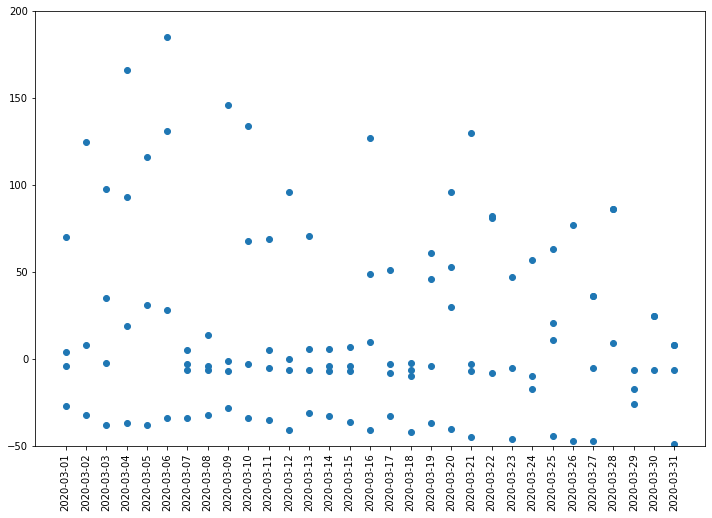

In [80]:
import matplotlib.pyplot as plt

xs = []
for ix, day in enumerate(pd_df['FlightDate']):
  xs += [ix] * 5

ys = []
for qs in pd_df['quartiles']:
  ys += qs

plt.scatter(xs, ys)
plt.xticks(range(len(pd_df['FlightDate'])), labels=pd_df['FlightDate'], rotation='vertical')
plt.gcf().set_size_inches(12, 8)
plt.gca().set_ylim(-50, 200)

(-50.0, 200.0)

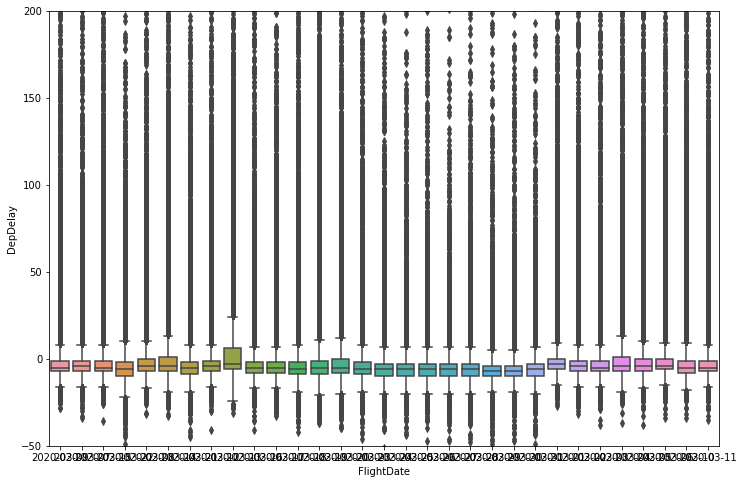

In [89]:
import seaborn as sns

sns.boxplot(data=df.toPandas(), x='FlightDate', y='DepDelay')
plt.gcf().set_size_inches(12, 8)
plt.gca().set_ylim(-50, 200)

## Test your "Big Data" prototype with small data

### Summary

This is the whole process, collected in one place as is:

### Pyspark job

In order to run the process in a cluster, we need to transform it into a pyspark job file. 

We need to tidy up the function definitions, add the relevant imports, and modify the input and output to use command-line arguments.

We will put the result in a file called mysparkjob.py:

```python
from __future__ import print_function
from pyspark.sql import types, functions, SparkSession
import sys

def zipsort(a, b):
    return sorted(zip(a, b))

def quartiles(histogram):
    area = 0
    result = []
    
    for value, percentage in histogram:
        if area == 0:
            result.append(value)
        elif area <= .25 and area + percentage > .25:
            result.append(value)
        elif area <= .5 and area + percentage > .5:
            result.append(value)
        elif area <= .75 and area + percentage > .75:
            result.append(value)
        area += percentage
    
    result.append(value)
    return result

if __name__=='__main__':
    
    file = sys.argv[1]
    out = sys.argv[2]
    
    spark = SparkSession.builder.getOrCreate()
    df = spark.read.csv(file, header= True, inferSchema=True)
    df = df.select(['FlightDate', 'DayOfWeek', 'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                    'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                    'DepTime', 'DepDelay', 'AirTime', 'Distance'])

    df2 = df.withColumn('Hour', (df['DepTime'] / 100).cast(types.IntegerType()))
    totals = df2.groupBy('Hour').count()
    distributions = df2.groupBy(['Hour', 'DepDelay']).count()
    annotated = distributions.join(totals, on='Hour')
    frequencies = annotated.withColumn('relative', distributions['count'] / totals['count'])
    groups = frequencies.groupBy(totals['Hour'])\
                        .agg(functions.collect_list('DepDelay').alias('delays'),
                             functions.collect_list('relative').alias('relatives'))



    zipsort_typed = functions.udf(zipsort, types.ArrayType(types.ArrayType(types.FloatType())))
    distributions = groups.withColumn('distributions', zipsort_typed('delays', 'relatives'))



    quartiles_udf = functions.udf(quartiles, returnType=types.ArrayType(types.FloatType()))

    result = distributions.select('Hour',
                                  quartiles_udf('distributions').alias('quartiles'))

    result.write.json(out)
    spark.stop()
```

In [2]:
!pip install pyspark==3.1.1

In [4]:
from pyspark.sql import SparkSession, types, functions
import sys

@functions.udf(types.ArrayType(types.FloatType()))
def quartiles(total, delays, counts):
  histogram = sorted(zip(delays, counts))
  result = []
  so_far = 0.0

  for delay, n in histogram:
    prev = so_far
    so_far += n / total

    if prev == 0.0:
      result.append(delay)
    if prev < .25 and so_far >= .25:
      result.append(delay)
    if prev < .5 and so_far >= .5:
      result.append(delay)
    if prev < .75 and so_far >= .75:
      result.append(delay)
    
  result.append(delay)

  return result


in_path = sys.argv[1]
out_path = sys.argv[2]

spark = SparkSession.builder.getOrCreate()


df = spark.read.csv(in_path, inferSchema=True, header=True)
df = df[['FlightDate', 'DayOfWeek', 'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                'DepTime', 'DepDelay', 'AirTime', 'Distance']]

totals = df.groupby('FlightDate').count()

distributions = df.groupby(['FlightDate', 'DepDelay']).count()

lists = distributions.groupby('FlightDate').agg(functions.collect_list('DepDelay').alias('depdelays'),
                                                functions.collect_list('count').alias('counts'))

joined = totals.join(lists, on='FlightDate')


result = joined.withColumn('quartiles', quartiles('count', 'depdelays', 'counts')).cache()

result.write.json(out_path)

### Running with spark-submit

If the following works, we are ready to test it in the cluster!

```python
spark-submit mysparkjob.py On_Time_On_Time_Performance_2015_8.csv out.csv
```